# LO neutral-current Drell–Yan in a form-factor basis (SM + contact terms)

This notebook implements the LO hadronic spectrum **dσ/dM** for
$$
pp \to \ell^+\ell^- + X
$$
using the **current–current / form-factor** decomposition
$$
\mathcal A \propto \sum_{q\in\{L,R\}}\sum_{\ell\in\{L,R\}}
(\bar q\gamma_\mu P_q q)(\bar \ell\gamma^\mu P_\ell \ell)\;F^{q\ell}(\hat s),
$$
with
$$
F^{q\ell}(\hat s)= \frac{e^2 Q_q Q_\ell}{\hat s}
+\frac{g_Z^{q}\,g_Z^{\ell}}{\hat s-m_Z^2+i m_Z\Gamma_Z}
+\frac{\epsilon^{q\ell}}{v^2}.
$$

Key outputs:
- **dσ/dM** for a chosen lepton flavour (e or μ), PDF set, and PDF member.
- **LFU ratio** $R_{\mu\mu/ee}(M)$.
- Simple scans over PDF members and/or EFT contact terms $\epsilon^{q\ell}$.

Assumptions: massless external fermions, LO QCD, inclusive in rapidity and lepton angle.


In [11]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import quad
import lhapdf

# Plotting defaults (LaTeX optional; disable if it causes issues on your system)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{amsmath, amssymb, bm}",
})
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 14


## 1. Run configuration (collider, PDFs, numerical controls)

In [26]:
# --- Collider configuration ---
sqrt_s = 14000.0  # GeV
s = sqrt_s**2

# --- PDF configuration ---
#pdf_set_name = "PDF4LHC21_40"
pdf_set_name = "PDF4EFT_baseline_noHMDY_100"
pset = lhapdf.getPDFSet(pdf_set_name)
pdfs = pset.mkPDFs()
n_members = len(pdfs)

def get_pdf(member: int = 0):
    """Return LHAPDF member (0=central, 1..N-1=replicas/eigenvectors)."""
    if member < 0 or member >= n_members:
        raise ValueError(f"member must be in [0, {n_members-1}] for {pdf_set_name}")
    return pdfs[member]

pdf_member = 0
pdf = get_pdf(pdf_member)

# --- Numerical integration controls ---
epsabs = 0.0
epsrel = 1e-4
quad_limit = 200

# Factorisation scale choice (change if desired)
def muF2(M):
    return M**2


LHAPDF 6.5.4 loading all 101 PDFs in set PDF4EFT_baseline_noHMDY_100
PDF4EFT_baseline_noHMDY_100, version 1; 101 PDF members


## 2. Electroweak inputs and chiral couplings

In [27]:
# --- Units ---
GeV2_to_pb = 0.389379e9  # 1 GeV^-2 = 0.389379 mb = 0.389379e9 pb

# --- EW parameters (reasonable defaults) ---
alpha_em = 1/127.95
e2 = 4*np.pi*alpha_em

sW2 = 0.23129
cW2 = 1.0 - sW2
sW = np.sqrt(sW2)
cW = np.sqrt(cW2)

mZ = 91.1876   # GeV
GammaZ = 2.4952  # GeV

Nc = 3.0
vEW = 246.0  # GeV

# Charges (units of |e|)
Q_l = -1.0  # charged lepton
Q_u = +2/3
Q_d = -1/3

# Weak isospin for LH components; RH has T3=0
T3_uL, T3_dL = +0.5, -0.5
T3_lL = -0.5
T3_R = 0.0

def gZ_chiral(Q: float, T3: float):
    """Chiral Z coupling g_Z^f for current \bar f gamma^mu P_{L/R} f.

    Convention:
      vertex = i * (e/(sW*cW)) * (T3 - Q*sW^2) * gamma^mu P_{L/R}
    where T3=±1/2 for LH, and T3=0 for RH.
    """
    return (np.sqrt(e2) / (sW*cW)) * (T3 - Q*sW2)  # has dimensionless coupling

# Quark map: PDG id, charge, T3 for LH component
quarks = {
    "u": {"pdg":  2, "Q": +2/3, "T3L": +0.5},
    "d": {"pdg":  1, "Q": -1/3, "T3L": -0.5},
    "s": {"pdg":  3, "Q": -1/3, "T3L": -0.5},
    "c": {"pdg":  4, "Q": +2/3, "T3L": +0.5},
    "b": {"pdg":  5, "Q": -1/3, "T3L": -0.5},
}

def z_prop(shat: float):
    """Complex Breit–Wigner propagator factor 1/(s - mZ^2 + i mZ ΓZ)."""
    return 1.0 / (shat - mZ**2 + 1j*mZ*GammaZ)


## 3. EFT contact terms $\epsilon^{q\ell}/v^2$

We parameterise contact interactions per **quark flavour**, **lepton flavour**, and **chirality**:
$$
(\bar q\gamma_\mu P_q q)(\bar\ell\gamma^\mu P_\ell\ell)\,\frac{\epsilon^{q\ell}}{v^2}.
$$

You can set these to zero (SM) or turn on LFU violation (e.g. only in the muon channel).


In [28]:
# Contact terms epsilon^{qchir, lchir} for each (quark, lepton flavour).
# Convention: epsilon is dimensionless; the amplitude uses epsilon/vEW^2.

# Chiral labels
CHIRALITIES = ("L", "R")

def make_eps_dict(default=0.0):
    """Create a nested dict eps[lepton_flavour][quark_name][qchir][lchir]."""
    eps = {}
    for lep in ("e", "mu"):
        eps[lep] = {}
        for q in quarks.keys():
            eps[lep][q] = {qc: {lc: float(default) for lc in CHIRALITIES} for qc in CHIRALITIES}
    return eps

eps = make_eps_dict(default=0.0)

# Example: turn on an LFU-violating LL contact term for muons only (edit as desired)
# eps["mu"]["u"]["L"]["L"] = +1e-3
# eps["mu"]["d"]["L"]["L"] = +1e-3

def set_universal_LL(lepton: str, value: float, flavours=("u","d","s","c","b")):
    """Convenience helper: set epsilon^{LL} for a set of quark flavours."""
    for q in flavours:
        eps[lepton][q]["L"]["L"] = float(value)

# Uncomment to test:
# set_universal_LL("mu", 1e-3)


## 4. Form factors and LO partonic cross section

For each chiral structure $(q,\ell)\in\{L,R\}^2$:
$$
F^{q\ell}(\hat s)= \frac{e^2 Q_q Q_\ell}{\hat s}
+\frac{g_Z^{q}\,g_Z^{\ell}}{\hat s-m_Z^2+i m_Z\Gamma_Z}
+\frac{\epsilon^{q\ell}}{v^2}.
$$

For massless external fermions, after averaging over initial spins/colours and integrating over the lepton angle,
$$
\boxed{
\hat\sigma(\hat s)= \frac{\hat s}{12\pi N_c}\;\sum_{q,\ell\in\{L,R\}}\left|F^{q\ell}(\hat s)\right|^2
}
$$
which reproduces the standard $\gamma/Z$ DY result when $\epsilon=0$.


In [29]:
def F_form_factor(shat: float, quark_name: str, lepton: str, qchir: str, lchir: str,
                  include_SM: bool=True, include_EFT: bool=True):
    """Return complex form factor F^{qchir,lchir}(shat) with dimension GeV^-2."""
    qinfo = quarks[quark_name]
    Qq = qinfo["Q"]
    Ql = Q_l

    F = 0.0 + 0.0j

    if include_SM:
        # photon piece (vector-like, same for L/R)
        F += e2 * Qq * Ql / shat

        # Z piece (chiral)
        # T3 depends on chirality
        T3q = qinfo["T3L"] if qchir == "L" else 0.0
        T3l = T3_lL if lchir == "L" else 0.0

        gZq = gZ_chiral(Qq, T3q)
        gZl = gZ_chiral(Ql, T3l)

        F += (gZq * gZl) * z_prop(shat)

    if include_EFT:
        F += eps[lepton][quark_name][qchir][lchir] / (vEW**2)

    return F

def sigmahat_qqbar_to_ll_formfactor(shat: float, quark_name: str, lepton: str,
                                   include_SM: bool=True, include_EFT: bool=True):
    """Inclusive LO partonic cross section (angle-integrated), in pb."""
    S = 0.0
    for qchir in CHIRALITIES:
        for lchir in CHIRALITIES:
            F = F_form_factor(shat, quark_name, lepton, qchir, lchir,
                              include_SM=include_SM, include_EFT=include_EFT)
            S += (F.real*F.real + F.imag*F.imag)  # |F|^2

    # hatσ = shat/(12π Nc) * Σ |F|^2   [GeV^-2]
    pref = shat / (12.0 * np.pi * Nc)
    return pref * S * GeV2_to_pb


## 5. Hadronic $d\sigma/dM$ at LO (rapidity integration)

At LO:
$$
x_{1,2} = \frac{M}{\sqrt s}e^{\pm y},\qquad y_{\max}=\ln\frac{\sqrt s}{M},
$$
and
$$
\frac{d\sigma}{dM} = \frac{2M}{s}\int_{-y_{\max}}^{y_{\max}}dy\;
\sum_q\Big[f_q(x_1)f_{\bar q}(x_2)+f_{\bar q}(x_1)f_q(x_2)\Big]\;\hat\sigma_{q\bar q}(M^2).
$$


In [30]:
def x1x2_from_My(M, y, sqrt_s=sqrt_s):
    tau = M / sqrt_s
    return tau * np.exp(y), tau * np.exp(-y)

def fq(pdf, pdg, x, Q2):
    # LHAPDF returns x*f(x,Q2); convert to f(x,Q2)
    if x <= 0.0 or x >= 1.0:
        return 0.0
    return pdf.xfxQ2(pdg, x, Q2) / x

def dy_integrand(y, M, pdf, lepton="mu", include_SM=True, include_EFT=True):
    Q2 = muF2(M)
    x1, x2 = x1x2_from_My(M, y)
    if (x1 <= 0.0) or (x1 >= 1.0) or (x2 <= 0.0) or (x2 >= 1.0):
        return 0.0

    shat = M**2

    total = 0.0
    for qname, qinfo in quarks.items():
        pdg = qinfo["pdg"]
        f_q_x1  = fq(pdf,  pdg, x1, Q2)
        f_qb_x1 = fq(pdf, -pdg, x1, Q2)
        f_q_x2  = fq(pdf,  pdg, x2, Q2)
        f_qb_x2 = fq(pdf, -pdg, x2, Q2)

        lum = f_q_x1 * f_qb_x2 + f_qb_x1 * f_q_x2
        total += lum * sigmahat_qqbar_to_ll_formfactor(shat, qname, lepton,
                                                       include_SM=include_SM, include_EFT=include_EFT)
    return total

def dsigma_dM(M, pdf, lepton="mu", include_SM=True, include_EFT=True,
              epsabs=epsabs, epsrel=epsrel, limit=quad_limit):
    """Return (dσ/dM, integration_error) in pb/GeV."""
    if M <= 0.0 or M >= sqrt_s:
        return 0.0, 0.0

    ymax = np.log(sqrt_s / M)

    val, err = quad(
        lambda y: dy_integrand(y, M, pdf, lepton=lepton, include_SM=include_SM, include_EFT=include_EFT),
        -ymax, ymax,
        epsabs=epsabs, epsrel=epsrel, limit=limit
    )

    pref = (2.0 * M) / s
    return pref * val, pref * err


## 6. Example: compute and plot $d\sigma/dM$ and $R_{\mu\mu/ee}$

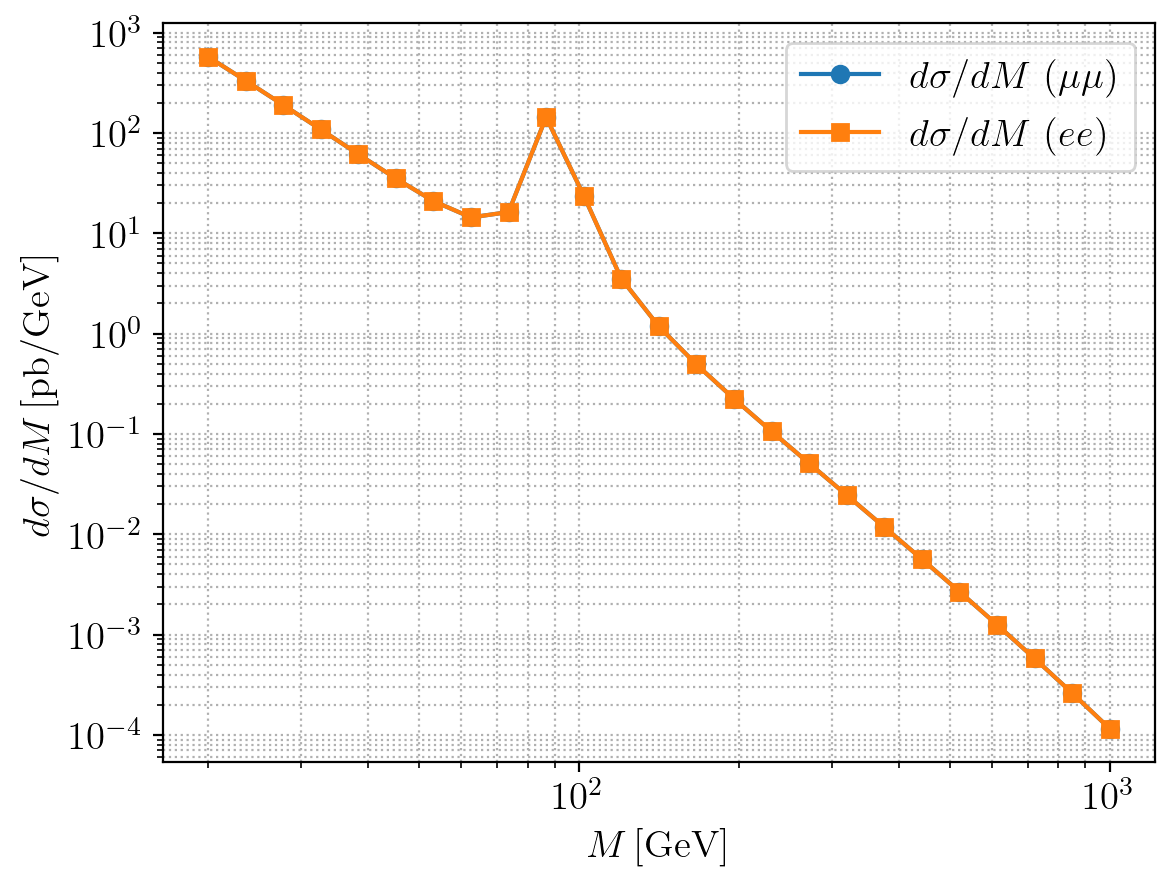

In [31]:
# --- Mass grid ---
M_min, M_max = 20.0, 1000.0
nM = 25
M_grid = np.logspace(np.log10(M_min), np.log10(M_max), nM)

pdf = get_pdf(pdf_member)

dsig_mu = np.zeros_like(M_grid)
dsig_e  = np.zeros_like(M_grid)
#R_grid  = np.zeros_like(M_grid)

for i, M in enumerate(M_grid):
    dsig_mu[i], _ = dsigma_dM(M, pdf, lepton="mu")
    dsig_e[i],  _ = dsigma_dM(M, pdf, lepton="e")
    #R_grid[i] = dsig_mu[i]/dsig_e[i] if dsig_e[i] > 0 else np.nan

fig = plt.figure()
plt.loglog(M_grid, dsig_mu, marker="o", label=r"$d\sigma/dM\ (\mu\mu)$")
plt.loglog(M_grid, dsig_e,  marker="s", label=r"$d\sigma/dM\ (ee)$")
plt.xlabel(r"$M\,[\mathrm{GeV}]$")
plt.ylabel(r"$d\sigma/dM\,[\mathrm{pb/GeV}]$")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.show()

#fig = plt.figure()
#plt.semilogx(M_grid, R_grid, marker="o")
#plt.xlabel(r"$M\,[\mathrm{GeV}]$")
#plt.ylabel(r"$R_{\mu\mu/ee}(M)$")
#plt.grid(True, which="both", ls=":")
#plt.show()

In [32]:
# Cross check
# Integrate dσ/dM and get the total cross section
def integrate_dsigma_dM(M_grid, dsig):
    return np.trapz(dsig, M_grid)

total_dsig_mu = integrate_dsigma_dM(M_grid, dsig_mu)

print(f"Total cross section (mu mu): {total_dsig_mu:.2f} pb")

Total cross section (mu mu): 7487.31 pb


In [7]:
def R_mumu_over_ee(M, pdf, include_SM=True, include_EFT=True):
    num, _ = dsigma_dM(M, pdf, lepton="mu", include_SM=include_SM, include_EFT=include_EFT)
    den, _ = dsigma_dM(M, pdf, lepton="e",  include_SM=include_SM, include_EFT=include_EFT)
    return np.nan if den == 0 else num/den


## 8. Scan over PDF members (band from replicas/eigenvectors)

This reproduces your existing functionality, but now for both flavours and the LFU ratio.


member 10/41 done


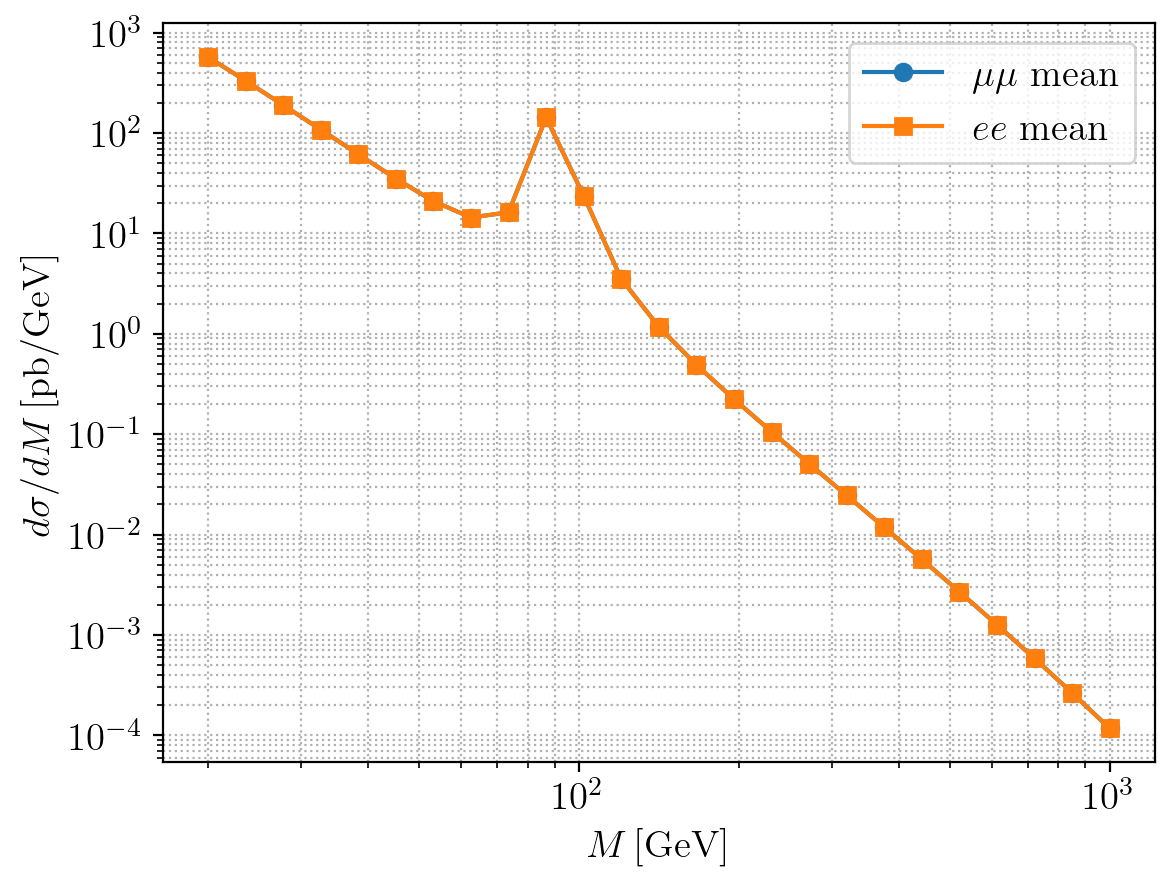

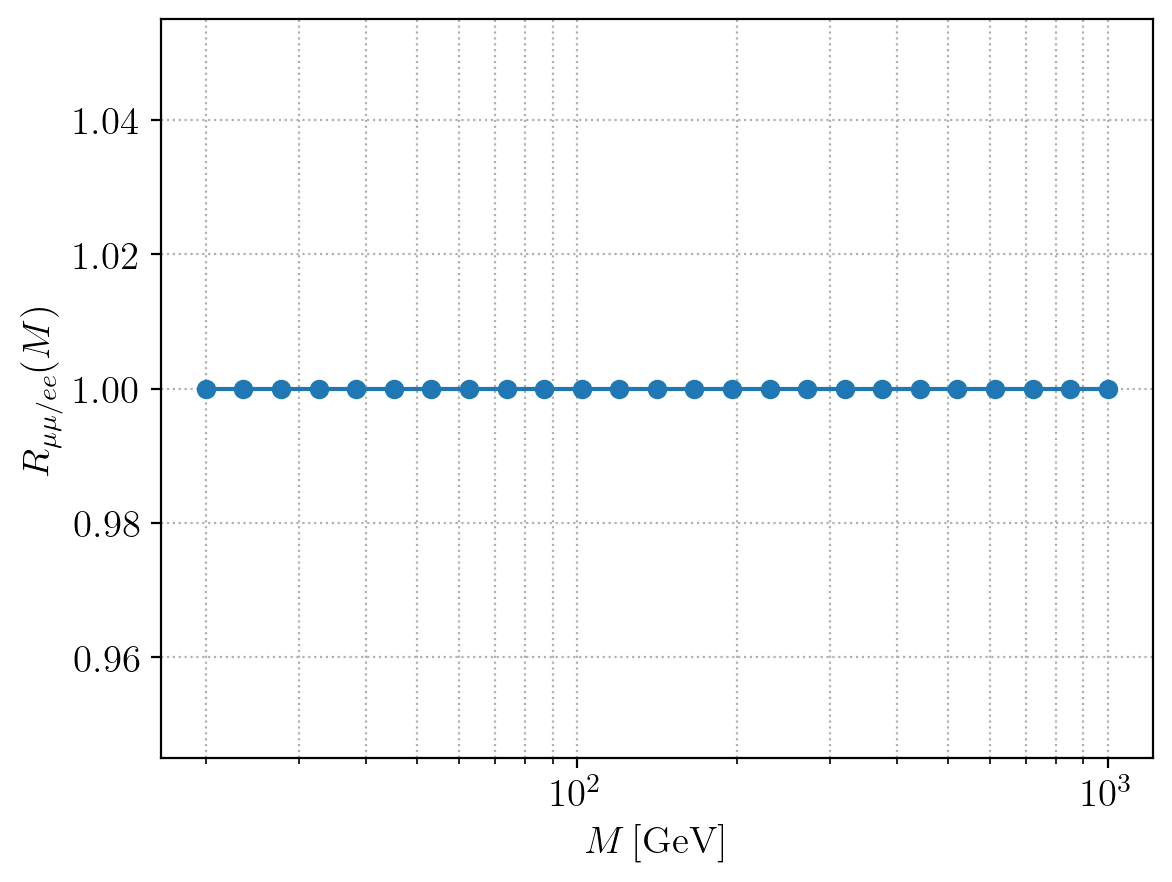

In [9]:
def scan_members(M_grid, members=None, include_SM=True, include_EFT=True):
    if members is None:
        members = list(range(n_members))

    vals_mu = np.zeros((len(members), len(M_grid)))
    vals_e  = np.zeros((len(members), len(M_grid)))
    for i, m in enumerate(members):
        pdf_m = get_pdf(m)
        for j, M in enumerate(M_grid):
            vals_mu[i, j], _ = dsigma_dM(M, pdf_m, lepton="mu", include_SM=include_SM, include_EFT=include_EFT)
            vals_e[i, j],  _ = dsigma_dM(M, pdf_m, lepton="e",  include_SM=include_SM, include_EFT=include_EFT)
        print(f"member {m+1}/{n_members} done", end="\r")
    print()

    R = np.where(vals_e > 0, vals_mu/vals_e, np.nan)

    out = {
        "members": np.array(members, dtype=int),
        "mu": vals_mu,
        "e": vals_e,
        "R": R,
        "mu_mean": np.nanmean(vals_mu, axis=0),
        "mu_std":  np.nanstd(vals_mu, axis=0),
        "e_mean":  np.nanmean(vals_e, axis=0),
        "e_std":   np.nanstd(vals_e, axis=0),
        "R_mean":  np.nanmean(R, axis=0),
        "R_std":   np.nanstd(R, axis=0),
    }
    return out

# Example: scan all members (can be slow). You can restrict, e.g. members=range(10).
scan = scan_members(M_grid, members=range(min(10, n_members)))

fig = plt.figure()
plt.loglog(M_grid, scan["mu_mean"], marker="o", label=r"$\mu\mu$ mean")
plt.fill_between(M_grid, scan["mu_mean"]-scan["mu_std"], scan["mu_mean"]+scan["mu_std"], alpha=0.3)
plt.loglog(M_grid, scan["e_mean"], marker="s", label=r"$ee$ mean")
plt.fill_between(M_grid, scan["e_mean"]-scan["e_std"], scan["e_mean"]+scan["e_std"], alpha=0.3)
plt.xlabel(r"$M\,[\mathrm{GeV}]$")
plt.ylabel(r"$d\sigma/dM\,[\mathrm{pb/GeV}]$")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.show()

fig = plt.figure()
plt.semilogx(M_grid, scan["R_mean"], marker="o")
plt.fill_between(M_grid, scan["R_mean"]-scan["R_std"], scan["R_mean"]+scan["R_std"], alpha=0.3)
plt.xlabel(r"$M\,[\mathrm{GeV}]$")
plt.ylabel(r"$R_{\mu\mu/ee}(M)$")
plt.grid(True, which="both", ls=":")
plt.show()


## 9. Turning on LFU-violating contact terms (example workflow)

Below is a minimal pattern you can reuse:
1. Set some \(\epsilon\) values (e.g. universal LL for muons).
2. Recompute spectra and/or ratios.
3. Compare to SM (set eps back to 0).

Important: this is an LO *shape* study; for realistic phenomenology you typically fold in QCD K-factors and EW corrections consistently in both channels.


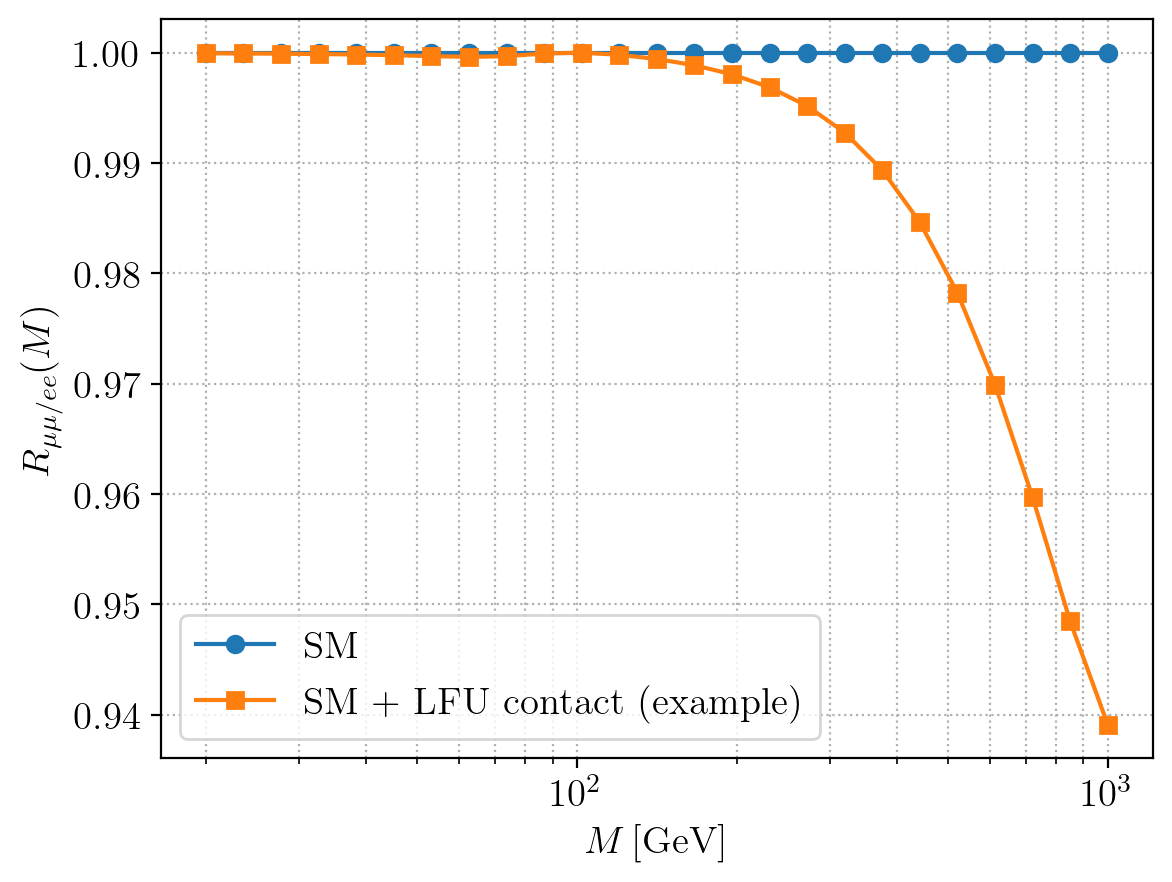

In [10]:
# --- Store current eps so you can restore later ---
import copy
eps_backup = copy.deepcopy(eps)

# Example: universal LL contact term for muons only
set_universal_LL("mu", 2e-3)  # edit magnitude
# Keep electrons SM-like
set_universal_LL("e", 0.0)

pdf = get_pdf(0)

dsig_mu_np = np.zeros_like(M_grid)
dsig_e_np  = np.zeros_like(M_grid)
R_np       = np.zeros_like(M_grid)
for i, M in enumerate(M_grid):
    dsig_mu_np[i], _ = dsigma_dM(M, pdf, lepton="mu", include_SM=True, include_EFT=True)
    dsig_e_np[i],  _ = dsigma_dM(M, pdf, lepton="e",  include_SM=True, include_EFT=True)
    R_np[i] = dsig_mu_np[i]/dsig_e_np[i] if dsig_e_np[i] > 0 else np.nan

# SM baseline (eps=0)
eps = make_eps_dict(default=0.0)
dsig_mu_sm = np.zeros_like(M_grid)
dsig_e_sm  = np.zeros_like(M_grid)
R_sm       = np.zeros_like(M_grid)
for i, M in enumerate(M_grid):
    dsig_mu_sm[i], _ = dsigma_dM(M, pdf, lepton="mu", include_SM=True, include_EFT=True)
    dsig_e_sm[i],  _ = dsigma_dM(M, pdf, lepton="e",  include_SM=True, include_EFT=True)
    R_sm[i] = dsig_mu_sm[i]/dsig_e_sm[i] if dsig_e_sm[i] > 0 else np.nan

# Plot ratio shift
fig = plt.figure()
plt.semilogx(M_grid, R_sm, marker="o", label="SM")
plt.semilogx(M_grid, R_np, marker="s", label="SM + LFU contact (example)")
plt.xlabel(r"$M\,[\mathrm{GeV}]$")
plt.ylabel(r"$R_{\mu\mu/ee}(M)$")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.show()

# --- Restore eps if desired ---
eps = eps_backup
